In [1]:
import sagemaker
from sagemaker.pytorch import PyTorchModel
import torch, torchvision

# Create and Save Model

In [ ]:
# Load DenseNet121 model from torchvision with pretrained weights
model = torchvision.models.densenet121(pretrained=True)

# Toggle inference mode
model.eval()

In [ ]:
# Trace the model on the random input
cv_input = torch.rand(1,3,224,224)
traced_model = torch.jit.trace(model, cv_input)
traced_model.graph

In [4]:
# Serialize model to file
torch.jit.save(traced_model, 'model.pt')

In [5]:
!tar -czvf densenet121.tar.gz model.pt

model.pt


# Upload Model Data to S3 for SageMaker

In [6]:
# Upload data to S3
sagemaker_session = sagemaker.Session()
tar_filename = 'densenet121.tar.gz'
model_data_s3_path = sagemaker_session.upload_data(path=tar_filename)

# Create SageMaker Endpoint to Host the Model

In [7]:
# script.py should be blank to use default EI model_fn and predict_fn
entry_point = 'script.py'
!cat script.py

import torch
import os

def model_fn(model_dir):
    model_path = os.path.join(model_dir, 'model.pt')
    return torch.jit.load(model_path, map_location=torch.device('cpu'))



In [8]:
# Now, create SageMaker endpoint from the saved model
region = "us-west-2"
role = "SageMaker-EI-Role"

instance_type = 'ml.c5.xlarge'

endpoint_name = 'webinar-densenet121-traced-no-ei'

In [9]:
torch.__version__

'1.4.0'

In [10]:
# Create and Deploy the SageMaker model without EI
pytorch_model = PyTorchModel(framework_version="1.4.0", model_data=model_data_s3_path, role=role, entry_point=entry_point, sagemaker_session=sagemaker_session)
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type=instance_type, endpoint_name=endpoint_name)

-------------!

# Now we have an endpoint! Let's use it



In [11]:
# Let's get an image to classify
import torchvision.transforms as transforms
import PIL
from PIL import Image

def transform_image(image):

  # ImageNet pretrained models required input images to have width/height of 224
  # and color channels normalized according to ImageNet distribution.
  image_process = transforms.Compose([transforms.Resize([224, 224]),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])
  transformed_image = image_process(image) # 3 x 224 x 224
  return transformed_image.unsqueeze(0) # Add dimension to become 1 x 3 x 224 x 224

image = Image.open('shiba.jpg')
image_input = transform_image(image)

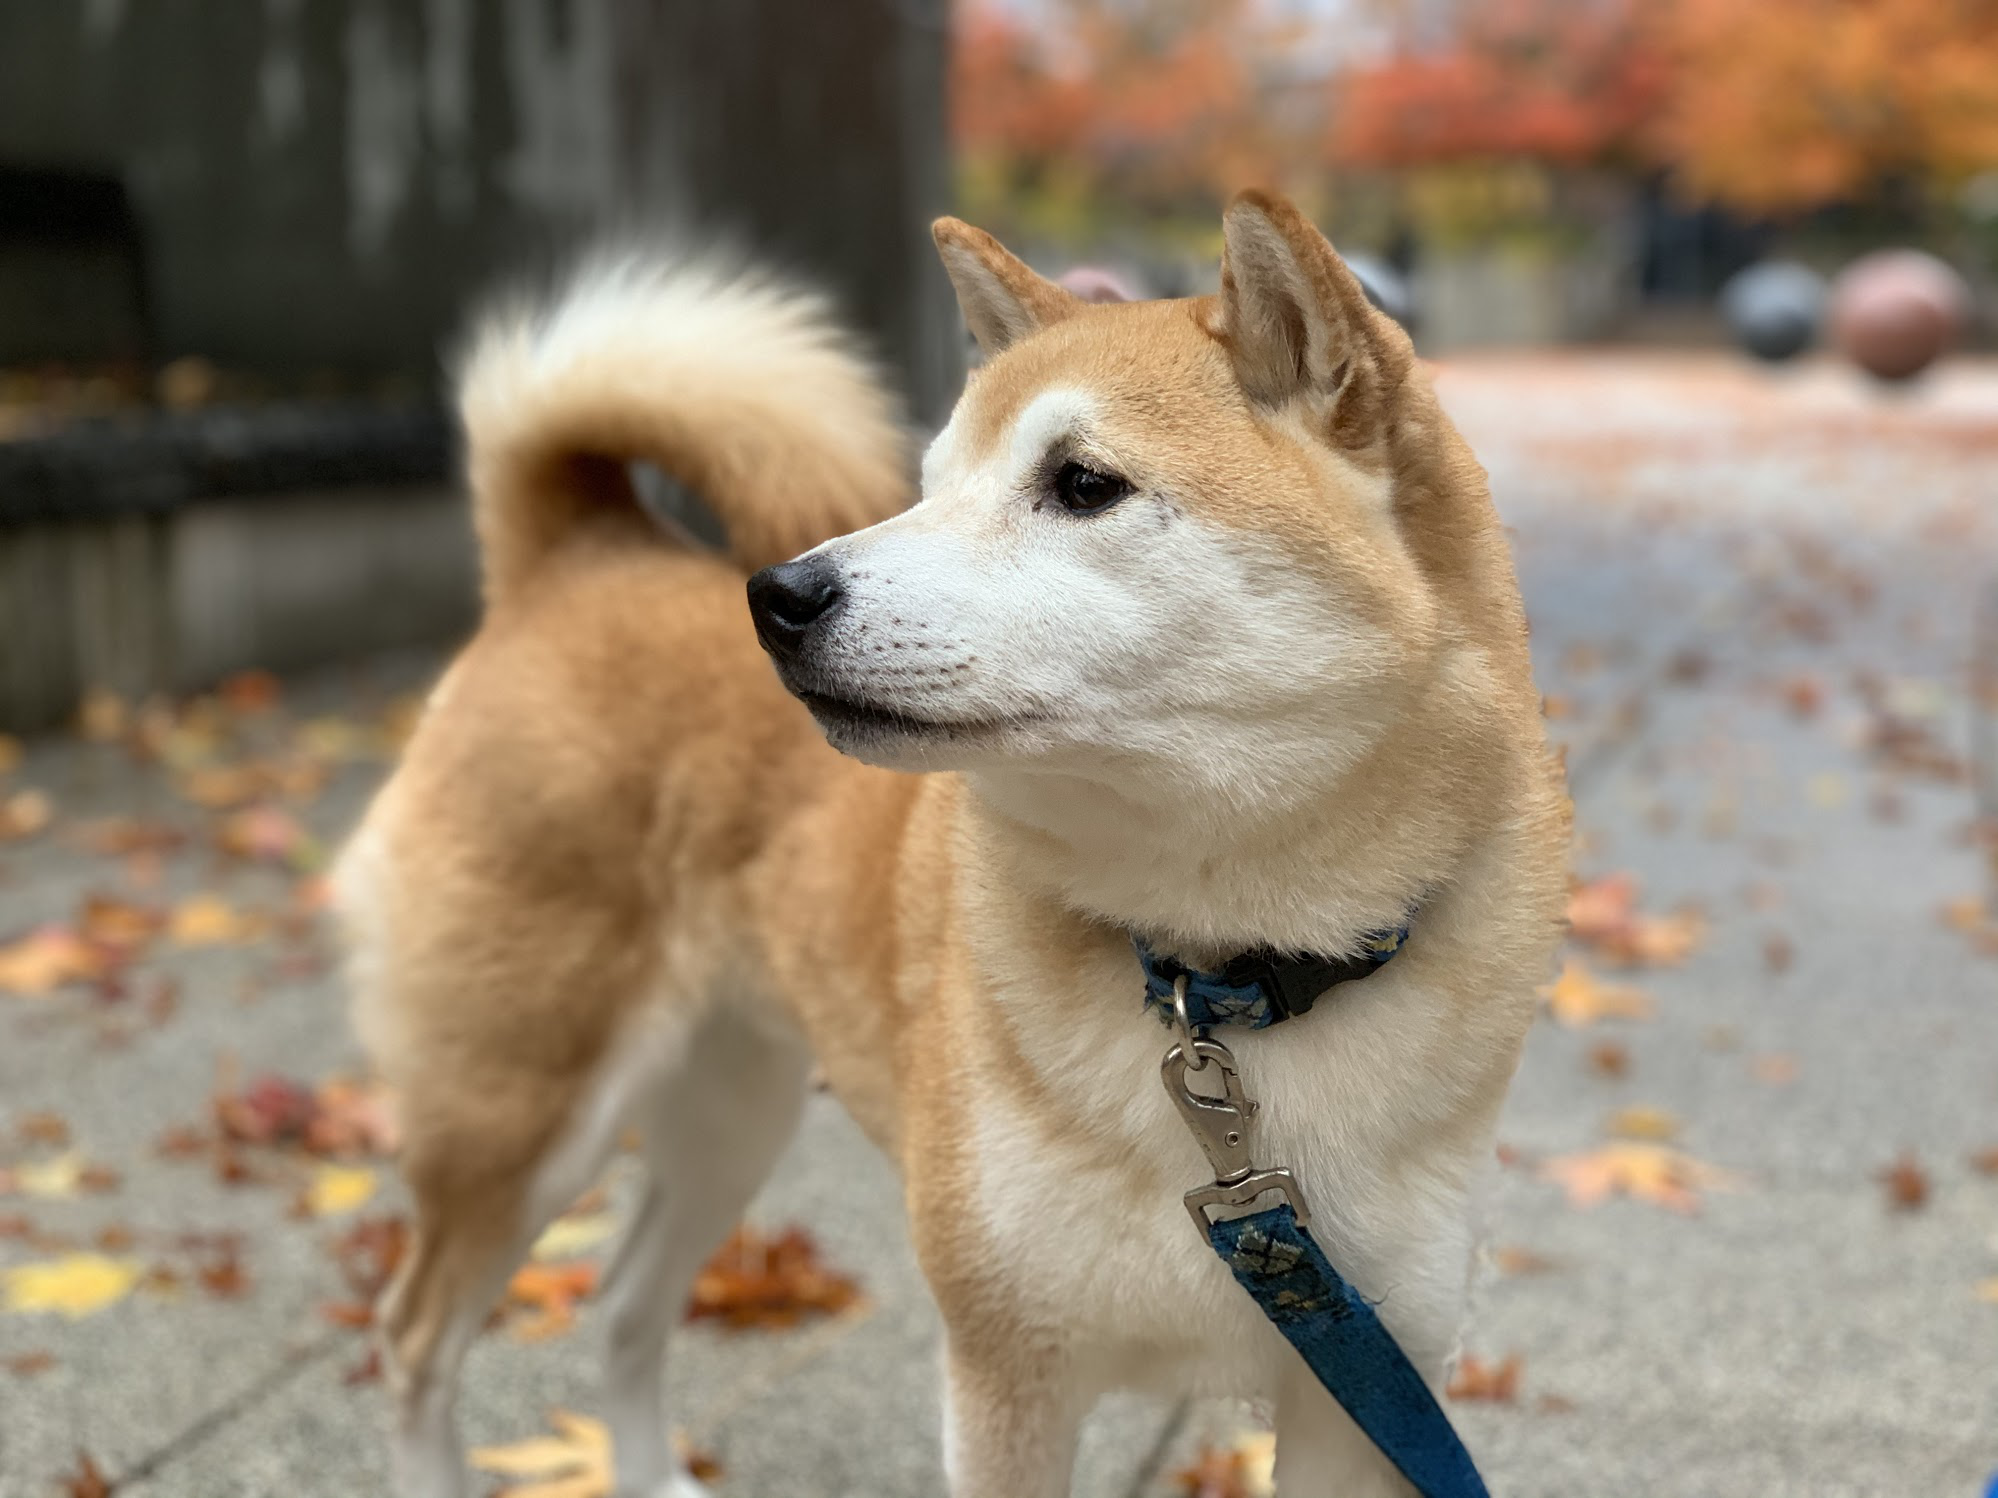

In [12]:
image

In [13]:
# Create SageMaker Predictor for sending predictions to hosted endpoint
from sagemaker.pytorch import PyTorchPredictor
predictor = PyTorchPredictor(endpoint_name)

In [14]:
# Run inference and look at result
output = predictor.predict(image_input)

probs = torch.nn.Softmax(dim=1)(torch.from_numpy(output))

In [15]:
classes = eval(open('imagenet_classes.txt').read())

In [16]:
# Print the top 5 classes with probabilities
pred_probs, pred_indices = torch.topk(probs, 5)
pred_probs = pred_probs.squeeze().numpy()
pred_indices = pred_indices.squeeze().numpy()

for i in range(len(pred_indices)):
  curr_class = classes[pred_indices[i]]
  curr_prob = pred_probs[i]
  print('{}: {:.4f}'.format(curr_class, curr_prob))

Eskimo dog, husky: 0.5987
Siberian husky: 0.1561
Norwegian elkhound, elkhound: 0.0796
dingo, warrigal, warragal, Canis dingo: 0.0663
basenji: 0.0232


# Let's Measure Latency without EI

In [17]:
# Run 100 warmup inferences so we can print some latency metrics
for i in range(100):
    output = predictor.predict(image_input)

In [18]:
import time, datetime

# Wait a bit to keep defined boundaries for CloudWatch
time.sleep(15)

# Gather statistics for the next 1000 inferences
cw_start = datetime.datetime.utcnow()

time.sleep(1)

for i in range(1000):
    output = predictor.predict(image_input)

cw_end = datetime.datetime.utcnow()
cw_end += datetime.timedelta(minutes=5)

In [19]:
import boto3
import math
def get_cloudwatch_latency_metrics(cw_start, cw_end):
    cloudwatch = boto3.client('cloudwatch')
    statistics=['SampleCount', 'Average', 'Minimum', 'Maximum']
    extended=['p50', 'p90', 'p95']
    
    # Period must be 1, 5, 10, 30, or multiple of 60
    # Calculate closest multiple of 60 to the total elapsed time
    factor = math.ceil((cw_end - cw_start).total_seconds() / 60)
    period = factor * 60
    print('Time elapsed: {} seconds'.format((cw_end - cw_start).total_seconds()))
    print('Using period of {} seconds\n'.format(period))
    model_latency_metrics = cloudwatch.get_metric_statistics(MetricName='ModelLatency',
                                             Dimensions=[{'Name': 'EndpointName',
                                                          'Value': endpoint_name},
                                                         {'Name': 'VariantName',
                                                          'Value': "AllTraffic"}],
                                             Namespace="AWS/SageMaker",
                                             StartTime=cw_start,
                                             EndTime=cw_end,
                                             Period=period,
                                             Statistics=statistics,
                                             ExtendedStatistics=extended
                                             )
    return model_latency_metrics

In [20]:
def print_cloudwatch_latency_metrics(model_latency_metrics):
    if len(model_latency_metrics['Datapoints']) > 0:
        print('{} latency datapoints ready'.format(int(model_latency_metrics['Datapoints'][0]['SampleCount'])))
        print('Side-car latency percentiles:')
        side_avg = model_latency_metrics['Datapoints'][0]['Average'] / 1000
        side_p50 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p50'] / 1000
        side_p90 = model_latency_metrics['Datapoints'][0]['ExtendedStatistics']['p90'] / 1000
        print('   Avg   |   P50   |   P90')
        print(' {:.4f} | {:.4f} | {:.4f}\n'.format(side_avg, side_p50, side_p90))

In [21]:
metrics = get_cloudwatch_latency_metrics(cw_start, cw_end)
print_cloudwatch_latency_metrics(metrics)

Time elapsed: 434.736336 seconds
Using period of 480 seconds

1000 latency datapoints ready
Side-car latency percentiles:
   Avg   |   P50   |   P90
 118.9296 | 118.1250 | 123.1395

